In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.sparse as sp
import scipy.sparse.linalg as spl

from tqdm import tqdm_notebook as tqdm
from PIL import Image

In [2]:
import warnings
warnings.filterwarnings('ignore', message='To copy construct from a tensor')

In [4]:
def load_image(filename):
    # loads an image in grayscale
    # returns a 2D array (height x width) of intensities between 0 and 1
    img = np.asarray(Image.open(filename).convert('L')) / 255.0
    return torch.tensor(img)

def show_image(arr):
    # Takes in an gray image with intensities from 0 to 1
    arr = np.array(arr.detach())
    arr = (arr * 255).astype(np.uint8)
    scaling = 500 / arr.shape[1]
    
    upscaled = (int(arr.shape[1] * scaling), int(arr.shape[0] * scaling))
    display(Image.fromarray(arr).resize(upscaled))

In [5]:
img = load_image('images/gray00.jpg')

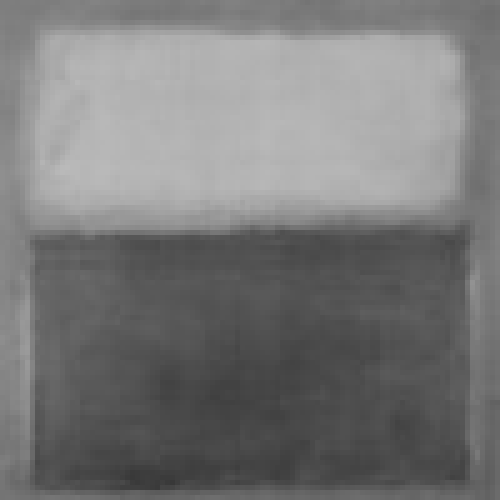

In [6]:
show_image(img)

In [7]:
def hardcode_boundary(f, internal_f):
    assert f[1:-1, 1:-1].shape == internal_f.shape

    res = f.clone()
    res[1:-1, 1:-1] = internal_f
    return res

class SecondOrderDiffEq:
    """
    A class that evaluates 2nd order nonlinear diffential equations
    of 2 variables using a discrete finite difference
    """
    def __init__(self, diff_eq_fn, num_weights, weights=None, h=0.01):
        self.diff_eq_fn = diff_eq_fn
        self.h = h
        self.num_weights = num_weights
        
        if weights is None:
            weights = torch.randn(num_weights)
        
        assert self.num_weights == len(weights)
        self.weights = torch.tensor(weights)

    def freeze(self):
        """
        Returns a copy of the SecondOrderDiffEq with weights that don't require grad
        """
        res = SecondOrderDiffEq(self.diff_eq_fn, self.num_weights, self.weights)
        res.weights.requires_grad = False
        return res

    def __call__(self, f):
        """
        Evaluate this DiffEq with the given values of the function value specified by `f`
        This uses a discrete finite difference.
        
        `f` should be a 2D torch.tensor
        """
        height, width = f.shape
        
        # constant term
        constant = torch.ones((f.shape[0] - 2, f.shape[1] - 2))
        
        # x, y coordinates
        x, y = np.meshgrid(np.arange(1, width - 1), np.arange(1, height - 1))
        x = torch.tensor(x).double() * self.h
        y = torch.tensor(y).double() * self.h
        
        # f_x and f_y
        f_x = (f[1:-1, 2:] - f[1:-1, :-2]) / (2 * self.h)
        f_y = (f[2:, 1:-1] - f[:-2, 1:-1]) / (2 * self.h)
        
        # f_xx and f_yy
        f_xx = (f[1:-1, 2:] - 2*f[1:-1,1:-1] + f[1:-1, :-2]) / (self.h ** 2)
        f_yy = (f[2:, 1:-1] - 2*f[1:-1,1:-1] + f[:-2, 1:-1]) / (self.h ** 2)
        
        # f_xy
        f_xy = (f[2:, 2:] - f[:-2, 2:] - f[2:, :-2] + f[:-2, :-2]) / (4 * self.h ** 2)
        
        # the internal part of f that excludes the boundary conditions
        f_internal = f[1:-1, 1:-1]
        
        res_internal = self.diff_eq_fn(
            weights=self.weights,
            constant=constant, x=x, y=y, f=f_internal,
            f_x=f_x, f_y=f_y, 
            f_xx=f_xx, f_xy=f_xy, f_yy=f_yy
        )
        
        return hardcode_boundary(torch.zeros(f.shape), res_internal)
    
    def fit(self, orig_image, lr=0.1, num_epochs=100, weight_penalty=0, **opt_kwargs):
        """
        Fit a differential equation to an image
        """
        orig_image = torch.tensor(orig_image).double()
        self.weights.requires_grad = True
        
        def closure():
            loss = torch.mean(self.__call__(orig_image) ** 2)
            loss += weight_penalty * torch.mean(1 / (diff_eq.weights.abs() + 1e-6))
            return loss
        
        self._lbfgs_training_loop([self.weights], closure, num_epochs, lr=lr, **opt_kwargs)
        self.weights.requires_grad = False
        return self

    def solve(self, orig_image, lr=0.1, num_epochs=100, **opt_kwargs):
        """
        Solve this differential equation using the boundary conditions
        specified by `orig_image`. Only the boundaries of `orig_image`
        are used, the remaining part of it can be arbitrary data.
        """
        internal_shape = (orig_image.shape[0] - 2, orig_image.shape[1] - 2)
        f_internal = torch.randn(internal_shape, requires_grad=True)
        
        def closure():
            f = hardcode_boundary(orig_image, f_internal)
            loss = torch.mean(self.__call__(f) ** 2)
            return loss
            
        self._lbfgs_training_loop([f_internal], closure, num_epochs, lr=lr, **opt_kwargs)
        return hardcode_boundary(orig_image, f_internal).detach()
    
    def _lbfgs_training_loop(self, parameters, closure, num_epochs=100, **opt_kwargs):
        opt = torch.optim.LBFGS(parameters, **opt_kwargs)
        
        start_time = time.time()
        last_time = None
        
        for i in range(num_epochs):
            try:
                opt.zero_grad()
                loss = closure()
                loss.backward()
                opt.step(lambda: loss)
                
                if loss.detach() < 1e-4:
                    break
                
                if last_time is None or time.time() - last_time > 1:
                    tot_time = time.time() - start_time
                    print(f'epoch {i} | {tot_time:.01f} sec | loss: {loss.detach():.3g}')
                    last_time = time.time()

            except KeyboardInterrupt:
                print('stopping early')
                break
        
        tot_time = time.time() - start_time
        print(f'epoch {i} | {tot_time:.01f} sec | loss: {loss.detach():.3g}')


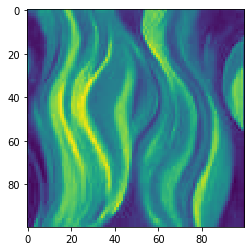

In [8]:
# def true_f(x, y):
#     x = x*0.01
#     y = y*0.01
#     return (x - x**2 + y**2) * np.exp(x)

# # generate a fake image from f(x, y) = exp(x) + exp(y)
# img = torch.zeros((10, 10))
# for x in range(10):
#     for y in range(10):
#         img[x][y] = true_f(x, y)
# img.shape

img = load_image('images/gray11.jpg')
plt.imshow(img)

In [10]:
def my_diffeq(weights, *, constant, x, y, f, f_x, f_y, f_xx, f_xy, f_yy):
    tot = 0
    w_idx = 0
    terms = [constant, x, y, f, f_x, f_y, f_xx, f_xy, f_yy]
    for t in terms[:]:
        terms.append(torch.cos(t))
    
    for i in range(len(terms)):
        tot += weights[w_idx] * terms[i]
        w_idx += 1
    
    for i in range(len(terms)):
        for j in range(i, len(terms)):
            tot += weights[w_idx] * terms[i] * terms[j]
            w_idx += 1
            
    return tot

num_weights = 18 + 18*19 // 2
diff_eq = SecondOrderDiffEq(my_diffeq, num_weights, h=0.01)
diff_eq.fit(img, lr=0.5, num_epochs=5000, weight_penalty=0)

epoch 0 | 0.0 sec | loss: 7.51e+11
epoch 81 | 1.0 sec | loss: 1.76e+07
epoch 152 | 2.0 sec | loss: 3.49e+06
epoch 221 | 3.0 sec | loss: 5.26e+05
epoch 293 | 4.1 sec | loss: 3.59e+05
epoch 367 | 5.1 sec | loss: 1.98e+05
epoch 442 | 6.1 sec | loss: 6.97e+04
epoch 517 | 7.1 sec | loss: 4.76e+04
epoch 592 | 8.1 sec | loss: 1.37e+04
epoch 667 | 9.1 sec | loss: 1.22e+04
epoch 742 | 10.1 sec | loss: 7.03e+03
epoch 816 | 11.1 sec | loss: 4.61e+03
epoch 889 | 12.1 sec | loss: 4.22e+03
epoch 962 | 13.1 sec | loss: 2.75e+03
epoch 1034 | 14.1 sec | loss: 2.62e+03
epoch 1107 | 15.1 sec | loss: 2.3e+03
epoch 1179 | 16.2 sec | loss: 1.85e+03
epoch 1252 | 17.2 sec | loss: 1.8e+03
epoch 1326 | 18.2 sec | loss: 1.65e+03
epoch 1399 | 19.2 sec | loss: 1.6e+03
epoch 1473 | 20.2 sec | loss: 1.41e+03
epoch 1542 | 21.2 sec | loss: 1.37e+03
epoch 1610 | 22.2 sec | loss: 1.21e+03
epoch 1681 | 23.2 sec | loss: 1.21e+03
epoch 1745 | 24.2 sec | loss: 1.18e+03
epoch 1811 | 25.2 sec | loss: 1.15e+03
epoch 1886 | 26.

In [ ]:
diff_eq.weights

In [ ]:
f = diff_eq.solve(img, lr=0.1, num_epochs=500, history_size=300)
print('f error:', torch.mean(diff_eq(f) ** 2))
plt.imshow(f.detach().numpy());

In [ ]:
img2 = torch.zeros((100, 100))
for x in range(100):
    for y in range(100):
        img2[x][y] = true_f(x, y)
img2.shape

In [ ]:
plt.imshow(img2)

In [ ]:
%%time
f = diff_eq.solve(img2, lr=0.3, num_epochs=50000, history_size=10)

In [ ]:
plt.imshow(f.detach().numpy())